#Import the libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import cv2 
from google.colab.patches import cv2_imshow
from PIL import Image
import sys
import math
import random
from skimage.transform import rotate, AffineTransform
from skimage.util import random_noise

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from torch.utils.data import TensorDataset, ConcatDataset
import random
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Preparation

In [ ]:
if torch.cuda.is_available():    
  # Tell PyTorch to use the GPU.    
  print(torch.device("cuda"))
  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('We will use the GPU:', torch.cuda.get_device_name(0))
  # If not...
else:
  print('No GPU available, using the CPU instead.')
  print(torch.device("cpu"))

cuda
There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# this cell is regarding the aumentation and normalization with the stats of data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2)),
    # transforms.RandomAffine(degrees=0, translate=(0.15, 0.15)),
    # transforms.RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = datasets.ImageFolder("/content/drive/MyDrive/projectDataset/animal90/animals", transform= transform)

In [ ]:
# this cell is spliting dataset to train and test
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
test_split = 0.2
dataset_size = len(dataset)
test_size = int(test_split * dataset_size)
train_size = dataset_size - test_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [ ]:
# this cell is spliting train to train and val
val_split = 0.2
train_size = len(train_dataset)
val_size = int(val_split * train_size)
train_size = train_size - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [ ]:
# Define the data loaders for the train and test sets
train_loader = DataLoader(train_dataset, batch_size=128, shuffle= True,
                          drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle= True,
                        drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle= True,
                         drop_last=True)

In [ ]:
num_class = len(dataset.classes)

In [ ]:
print(num_class)

85


# Resnet 18

In [ ]:
# Define the ResNet18 model
model = torchvision.models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_class)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(DEVICE)

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Train phase
from tqdm import tqdm

# Define the number of epochs
num_epochs = 50
loss_train = []
loss_val = []
loss_test = []

accuracy_train = []
accuracy_val = []
accuracy_test = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss_train = 0.0
    correct_train = 0
    total_train = 0
    running_loss_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # loss
        running_loss_train += loss.item()
        # accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
    accuracy = 100 * correct_train / total_train
    loss_train.append(running_loss_train/len(train_loader))
    accuracy_train.append(accuracy)
    print(f"Accuracy of the network on the train images after {epoch + 1} epochs is: {accuracy}")

    # Evaluate the model on validation
    model.eval()
    correct_val = 0
    total_val = 0
    running_loss_val = 0
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = val_data
            val_inputs = val_inputs.to(DEVICE)
            val_labels = val_labels.to(DEVICE)
            # loss
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            running_loss_val += loss.item()
            # accuracy
            _, predicted_val = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()
    accuracy = 100 * correct_val / total_val
    loss_val.append(running_loss_val/len(val_loader))        
    accuracy_val.append(accuracy)
    print(f"Accuracy of the network on the val images after {epoch + 1} epochs is: {accuracy}")

In [ ]:
#save the path
model_save_name = 'resnet18.pt'
path = f"/content/drive/MyDrive/projectDataset/animal90/{model_save_name}" 
torch.save(model.state_dict(), path)

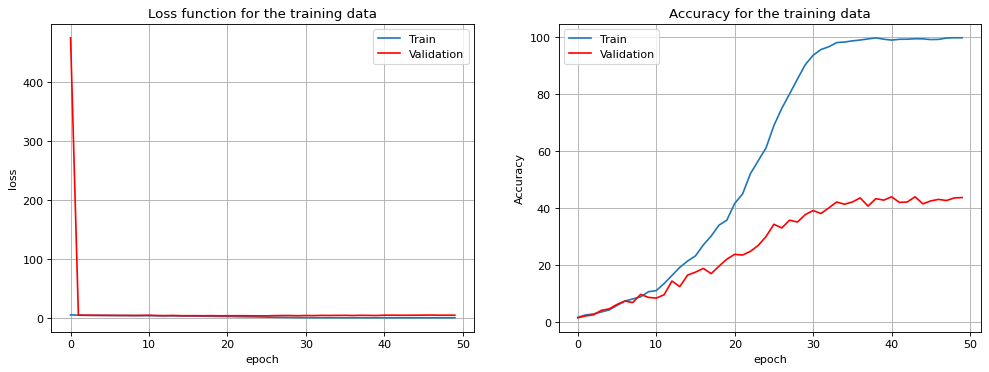

In [ ]:
# plot train and val and test accuracy 
plt.figure(figsize=(15, 5), dpi=80)

plt.subplot(1, 2, 1)
plt.plot(loss_train, label="Train")
plt.plot(loss_val, color='red', label="Validation")
plt.title('Loss function for the training data')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_train, label="Train")
plt.plot(accuracy_val, color='red', label="Validation")
plt.title('Accuracy for the training data')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

In [ ]:
# Evaluate the model on test
model.eval()
correct_test = 0
total_test = 0
running_loss_test = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss_test += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
accuracy_test = 100 * correct_test / total_test
loss_test = running_loss_test/len(test_loader)
print(f"Accuracy of the network on the test images is: {accuracy_test}")
print(f"Loss of the network on the test images is: {loss_test}")

In [ ]:
y_pred = []
y_true = []
for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [ ]:
# save accuracy and loss
import pickle
with open("/content/drive/MyDrive/projectDataset/animal90/accuracy_resnet18.txt", "wb") as fp:
    pickle.dump(accuracy_train, fp)
    pickle.dump(accuracy_val, fp)
    pickle.dump(accuracy_test, fp)
    pickle.dump(y_pred, fp)
    pickle.dump(y_true, fp)

with open("/content/drive/MyDrive/projectDataset/animal90/loss_resnet18.txt", "wb") as fp:
    pickle.dump(loss_train, fp)
    pickle.dump(loss_val, fp)
    pickle.dump(loss_test, fp)

In [ ]:
recall = recall_score(y_true, y_pred, average='micro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)
print(f'Recall Score is: {recall}')
print(f'Precision Score is : {precision}')
print(f'F1 measure is: {f1}')
print(f'Accuracy Score: {accuracy}')

#ShuffleNetV2

In [ ]:
# Define the ShuflleNetV2 model
model = torchvision.models.shufflenet_v2_x1_0(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_class)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(DEVICE)

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Train phase
from tqdm import tqdm

# Define the number of epochs
num_epochs = 50
loss_train = []
loss_val = []
loss_test = []

accuracy_train = []
accuracy_val = []
accuracy_test = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss_train = 0.0
    correct_train = 0
    total_train = 0
    running_loss_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # loss
        running_loss_train += loss.item()
        # accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
    accuracy = 100 * correct_train / total_train
    loss_train.append(running_loss_train/len(train_loader))
    accuracy_train.append(accuracy)
    print(f"Accuracy of the network on the train images after {epoch + 1} epochs is: {accuracy}")

    # Evaluate the model on validation
    model.eval()
    correct_val = 0
    total_val = 0
    running_loss_val = 0
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = val_data
            val_inputs = val_inputs.to(DEVICE)
            val_labels = val_labels.to(DEVICE)
            # loss
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            running_loss_val += loss.item()
            # accuracy
            _, predicted_val = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()
    accuracy = 100 * correct_val / total_val
    loss_val.append(running_loss_val/len(val_loader))        
    accuracy_val.append(accuracy)
    print(f"Accuracy of the network on the val images after {epoch + 1} epochs is: {accuracy}")

In [ ]:
#save the path
model_save_name = 'shufflenet_v2_x1_0.pt'
path = f"/content/drive/MyDrive/projectDataset/animal90/{model_save_name}" 
torch.save(model.state_dict(), path)

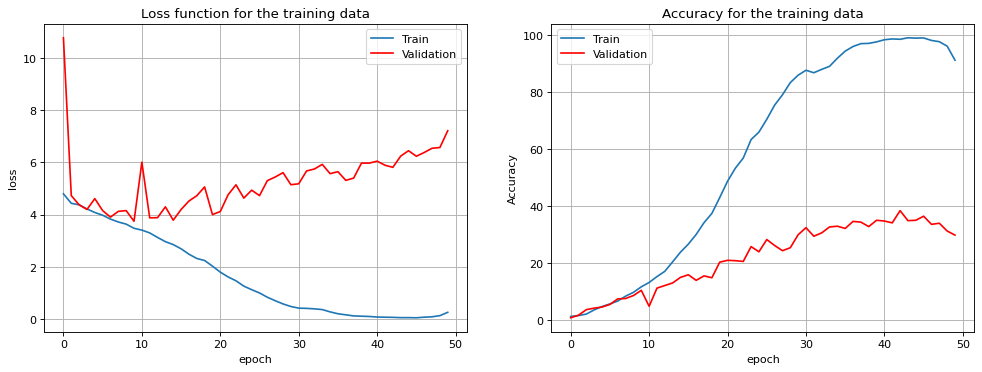

In [ ]:
# plot train and val and test accuracy 
plt.figure(figsize=(15, 5), dpi=80)

plt.subplot(1, 2, 1)
plt.plot(loss_train, label="Train")
plt.plot(loss_val, color='red', label="Validation")
plt.title('Loss function for the training data')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_train, label="Train")
plt.plot(accuracy_val, color='red', label="Validation")
plt.title('Accuracy for the training data')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

In [ ]:
# Evaluate the model on test
model.eval()
correct_test = 0
total_test = 0
running_loss_test = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss_test += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
accuracy_test = 100 * correct_test / total_test
loss_test = running_loss_test/len(test_loader)
print(f"Accuracy of the network on the test images is: {accuracy_test}")
print(f"Loss of the network on the test images is: {loss_test}")

Accuracy of the network on the test images is: 25.68359375
Loss of the network on the test images is: 7.656527519226074


In [ ]:
y_pred = []
y_true = []
for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [ ]:
# save accuracy and loss
import pickle
with open("/content/drive/MyDrive/projectDataset/animal90/accuracy_mobilenet_v2.txt", "wb") as fp:
    pickle.dump(accuracy_train, fp)
    pickle.dump(accuracy_val, fp)
    pickle.dump(accuracy_test, fp)
    pickle.dump(y_pred, fp)
    pickle.dump(y_true, fp)

with open("/content/drive/MyDrive/projectDataset/animal90/loss_mobilenet_v2.txt", "wb") as fp:
    pickle.dump(loss_train, fp)
    pickle.dump(loss_val, fp)
    pickle.dump(loss_test, fp)

In [ ]:
recall = recall_score(y_true, y_pred, average='micro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)
print(f'Recall Score is: {recall}')
print(f'Precision Score is : {precision}')
print(f'F1 measure is: {f1}')
print(f'Accuracy Score: {accuracy}')

#MobileNetV2

In [ ]:
# Define the ShuflleNetV2 model
model = torchvision.models.mobilenet_v2(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_class)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(DEVICE)

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Train phase
from tqdm import tqdm

# Define the number of epochs
num_epochs = 50
loss_train = []
loss_val = []
loss_test = []

accuracy_train = []
accuracy_val = []
accuracy_test = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss_train = 0.0
    correct_train = 0
    total_train = 0
    running_loss_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # loss
        running_loss_train += loss.item()
        # accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
    accuracy = 100 * correct_train / total_train
    loss_train.append(running_loss_train/len(train_loader))
    accuracy_train.append(accuracy)
    print(f"Accuracy of the network on the train images after {epoch + 1} epochs is: {accuracy}")

    # Evaluate the model on validation
    model.eval()
    correct_val = 0
    total_val = 0
    running_loss_val = 0
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = val_data
            val_inputs = val_inputs.to(DEVICE)
            val_labels = val_labels.to(DEVICE)
            # loss
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            running_loss_val += loss.item()
            # accuracy
            _, predicted_val = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()
    accuracy = 100 * correct_val / total_val
    loss_val.append(running_loss_val/len(val_loader))        
    accuracy_val.append(accuracy)
    print(f"Accuracy of the network on the val images after {epoch + 1} epochs is: {accuracy}")

#save the path
model_save_name = 'mobilenet_v2.pt'
path = f"/content/drive/MyDrive/projectDataset/animal90/{model_save_name}" 
torch.save(model.state_dict(), path)    

In [ ]:
#save the path
model_save_name = 'mobilenet_v2.pt'
path = f"/content/drive/MyDrive/projectDataset/animal90/{model_save_name}" 
torch.save(model.state_dict(), path)

In [ ]:
# plot train and val and test accuracy 
plt.figure(figsize=(15, 5), dpi=80)

plt.subplot(1, 2, 1)
plt.plot(loss_train, label="Train")
plt.plot(loss_val, color='red', label="Validation")
plt.title('Loss function for the training data')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_train, label="Train")
plt.plot(accuracy_val, color='red', label="Validation")
plt.title('Accuracy for the training data')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

In [ ]:
# Evaluate the model on test
model.eval()
correct_test = 0
total_test = 0
running_loss_test = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss_test += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
accuracy_test = 100 * correct_test / total_test
loss_test = running_loss_test/len(test_loader)
print(f"Accuracy of the network on the test images is: {accuracy_test}")
print(f"Loss of the network on the test images is: {loss_test}")

In [ ]:
y_pred = []
y_true = []
for inputs, labels in test_loader:
        inputs = inputs.to(DEVICE)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [ ]:
# save accuracy and loss
import pickle
with open("/content/drive/MyDrive/projectDataset/animal90/accuracy_mobilenet_v2.txt", "wb") as fp:
    pickle.dump(accuracy_train, fp)
    pickle.dump(accuracy_val, fp)
    pickle.dump(accuracy_test, fp)
    pickle.dump(y_pred, fp)
    pickle.dump(y_true, fp)

with open("/content/drive/MyDrive/projectDataset/animal90/loss_mobilenet_v2.txt", "wb") as fp:
    pickle.dump(loss_train, fp)
    pickle.dump(loss_val, fp)
    pickle.dump(loss_test, fp)

In [ ]:
recall = recall_score(y_true, y_pred, average='micro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)
print(f'Recall Score is: {recall}')
print(f'Precision Score is : {precision}')
print(f'F1 measure is: {f1}')
print(f'Accuracy Score: {accuracy}')

# Transfer Learning - ShuffleNet

In [ ]:
# Define the ShuflleNetV2 model
model = torchvision.models.shufflenet_v2_x1_0(weights='ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 90)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(DEVICE)

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Train phase
from tqdm import tqdm

# Define the number of epochs
num_epochs = 50
loss_train = []
loss_val = []
loss_test = []

accuracy_train = []
accuracy_val = []
accuracy_test = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss_train = 0.0
    correct_train = 0
    total_train = 0
    running_loss_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # loss
        running_loss_train += loss.item()
        # accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
    accuracy = 100 * correct_train / total_train
    loss_train.append(running_loss_train/len(train_loader))
    accuracy_train.append(accuracy)
    print(f"Accuracy of the network on the train images after {epoch + 1} epochs is: {accuracy}")

    # Evaluate the model on validation
    model.eval()
    correct_val = 0
    total_val = 0
    running_loss_val = 0
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = val_data
            val_inputs = val_inputs.to(DEVICE)
            val_labels = val_labels.to(DEVICE)
            # loss
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            running_loss_val += loss.item()
            # accuracy
            _, predicted_val = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()
    accuracy = 100 * correct_val / total_val
    loss_val.append(running_loss_val/len(val_loader))        
    accuracy_val.append(accuracy)
    print(f"Accuracy of the network on the val images after {epoch + 1} epochs is: {accuracy}")

In [ ]:
#save the path
model_save_name = 'shufflenet_v2_x1_0_pretrained.pt'
path = f"/content/drive/MyDrive/projectDataset/animal90/{model_save_name}" 
torch.save(model.state_dict(), path)

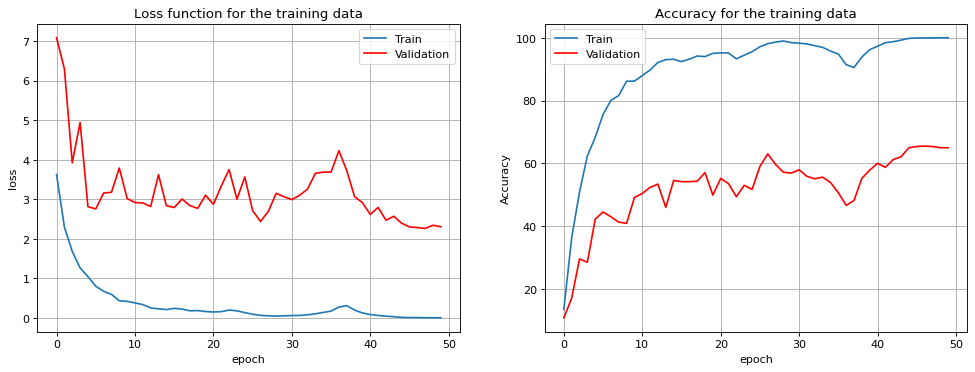

In [ ]:
# plot train and val and test accuracy 
plt.figure(figsize=(15, 5), dpi=80)

plt.subplot(1, 2, 1)
plt.plot(loss_train, label="Train")
plt.plot(loss_val, color='red', label="Validation")
plt.title('Loss function for the training data')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_train, label="Train")
plt.plot(accuracy_val, color='red', label="Validation")
plt.title('Accuracy for the training data')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

In [ ]:
# Evaluate the model on test
model.eval()
correct_test = 0
total_test = 0
running_loss_test = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(val_outputs, val_labels)
        running_loss_test += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
accuracy = 100 * correct_test / total_test
loss_test = running_loss_test/len(test_loader)
print(f"Accuracy of the network on the test images is: {accuracy}")
print(f"Loss of the network on the test images is: {loss_test}")

Accuracy of the network on the test images is: 66.89453125
Loss of the network on the test images is: 2.102228879928589


In [ ]:
y_pred = []
y_true = []
for inputs, labels in test_loader:
        input = input.to(DEVICE)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [ ]:
# save accuracy and loss
import pickle
with open("/content/drive/MyDrive/projectDataset/animal90/accuracy_mobilenet_v2.txt", "wb") as fp:
    pickle.dump(accuracy_train, fp)
    pickle.dump(accuracy_val, fp)
    pickle.dump(accuracy_test, fp)
    pickle.dump(y_pred, fp)
    pickle.dump(y_true, fp)

with open("/content/drive/MyDrive/projectDataset/animal90/loss_mobilenet_v2.txt", "wb") as fp:
    pickle.dump(loss_train, fp)
    pickle.dump(loss_val, fp)
    pickle.dump(loss_test, fp)

In [ ]:
recall = recall_score(y_true, y_pred, average='micro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)
print(f'Recall Score is: {recall}')
print(f'Precision Score is : {precision}')
print(f'F1 measure is: {f1}')
print(f'Accuracy Score: {accuracy}')

# Transfer Learning - MobileNet

In [ ]:
# Define the ShuflleNetV2 model
model = torchvision.models.mobilenet_v2(weights='MobileNet_V2_Weights.DEFAULT')
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 90)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 2)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(DEVICE)

In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
# Train phase
from tqdm import tqdm

# Define the number of epochs
num_epochs = 50
loss_train = []
loss_val = []
loss_test = []

accuracy_train = []
accuracy_val = []
accuracy_test = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss_train = 0.0
    correct_train = 0
    total_train = 0
    running_loss_train = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # loss
        running_loss_train += loss.item()
        # accuracy
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
    accuracy = 100 * correct_train / total_train
    loss_train.append(running_loss_train/len(train_loader))
    accuracy_train.append(accuracy)
    print(f"Accuracy of the network on the train images after {epoch + 1} epochs is: {accuracy}")

    # Evaluate the model on validation
    model.eval()
    correct_val = 0
    total_val = 0
    running_loss_val = 0
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = val_data
            val_inputs = val_inputs.to(DEVICE)
            val_labels = val_labels.to(DEVICE)
            # loss
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            running_loss_val += loss.item()
            # accuracy
            _, predicted_val = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted_val == val_labels).sum().item()
    accuracy = 100 * correct_val / total_val
    loss_val.append(running_loss_val/len(val_loader))        
    accuracy_val.append(accuracy)
    print(f"Accuracy of the network on the val images after {epoch + 1} epochs is: {accuracy}")

In [ ]:
#save the path
model_save_name = 'mobilenet_v2_pretrained.pt'
path = f"/content/drive/MyDrive/projectDataset/animal90/{model_save_name}" 
torch.save(model.state_dict(), path)

In [ ]:
# plot train and val and test accuracy 
plt.figure(figsize=(15, 5), dpi=80)

plt.subplot(1, 2, 1)
plt.plot(loss_train, label="Train")
plt.plot(loss_val, color='red', label="Validation")
plt.title('Loss function for the training data')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_train, label="Train")
plt.plot(accuracy_val, color='red', label="Validation")
plt.title('Accuracy for the training data')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

In [ ]:
# Evaluate the model on test
model.eval()
correct_test = 0
total_test = 0
running_loss_test = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(val_outputs, val_labels)
        running_loss_test += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
accuracy = 100 * correct_test / total_test
loss_test = running_loss_test/len(test_loader)
print(f"Accuracy of the network on the test images is: {accuracy}")
print(f"Loss of the network on the test images is: {loss_test}")

In [ ]:
y_pred = []
y_true = []
for inputs, labels in test_loader:
        input = input.to(DEVICE)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

In [ ]:
# save accuracy and loss
import pickle
with open("/content/drive/MyDrive/projectDataset/animal90/accuracy_mobilenet_v2.txt", "wb") as fp:
    pickle.dump(accuracy_train, fp)
    pickle.dump(accuracy_val, fp)
    pickle.dump(accuracy_test, fp)
    pickle.dump(y_pred, fp)
    pickle.dump(y_true, fp)

with open("/content/drive/MyDrive/projectDataset/animal90/loss_mobilenet_v2.txt", "wb") as fp:
    pickle.dump(loss_train, fp)
    pickle.dump(loss_val, fp)
    pickle.dump(loss_test, fp)

In [ ]:
recall = recall_score(y_true, y_pred, average='micro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
accuracy = accuracy_score(y_true, y_pred)
print(f'Recall Score is: {recall}')
print(f'Precision Score is : {precision}')
print(f'F1 measure is: {f1}')
print(f'Accuracy Score: {accuracy}')